In [36]:
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
def extract(seq, pos):
    '''Given a sequence and a position, return a 13-mer centered on the position.'''
    if pos < 7:
        seq = 'X'*(7-pos) + seq
        pos = 7
    elif len(seq) - pos < 6:
        seq = seq + 'X'*(6 - (len(seq) - pos))  
    return seq[pos-7:pos+6]

data = pd.read_csv('Ubiquitination_sites.txt', sep='\t')
data1 = data.drop(['PLMD ID', 'Species', 'PMIDs', 'Type', 'Uniprot Accession'], axis=1)
position = data1['Position']

positive = list()
for i in range(8000):
    sequence = data1['Sequence'][i]
    pos = position[i] 
    positive.append(extract(sequence, pos))

data1['positive'] = positive


In [38]:
# merge the identical sequences
data2 = pd.DataFrame(data1.groupby('Sequence').apply(lambda x: x['Position'].tolist()))
data2.reset_index(inplace=True)
data2.columns = ['sequence', 'positive'] # change names
sequences = data2['sequence']
all_K_position = []
for sequence in sequences:
    # identify all the positions of K
    K_position = [i for i in range(len(sequence)) if sequence[i] == 'K']
    all_K_position.append(K_position)
data2['all'] = all_K_position

negatives = []
for i in range(len(data2)):
    positive = data2['positive'][i]
    all_position = data2['all'][i]
    negative = [a+1 for a in all_position if all(abs(a - b) > 6 for b in positive)] # remove negatives that are too close to the positive
    negatives.append(negative)
data2['negative'] = negatives

In [41]:
# output positive and negative sequences
negative = open('negative.txt', 'w')
neg_seq = []
i = 0
for row in range(len(sequences)):
    # write negatives
    sequence = sequences[row]
    for pos in data2['negative'][row]: 
        negative.write('> '+ str(i) + '\n')
        seq = extract(sequence, pos)
        negative.write(seq + '\n')
        neg_seq.append(seq)
        i += 1
negative.close()

positive = open('positive.txt', 'w')
pos_seq = []
for i in range(8000):
    positive.write('> '+str(i) + '\n')
    seq2 = data1['positive'][i]
    positive.write(seq2 + '\n')
    pos_seq.append(seq2)
positive.close()

In [70]:
# calculate the frequency of each amino acid
# initialize the dictionary
def calculate_AAC(seqlist):
    frq = dict(zip('ACDEFGHIKLMNPQRSTVWY', [0]*20))
    for seq in seqlist:
        for aa in frq.keys():
            frq[aa] += seq.count(aa)
    # normalize the frequency
    for aa in frq.keys():
        frq[aa] = frq[aa]/len(seqlist)/13
    return frq

In [71]:
pos_frq = calculate_AAC(pos_seq)
neg_frq = calculate_AAC(neg_seq)

Text(0.5, 1.0, 'Comparsion of AAC between positive and negative sequences')

<Figure size 2000x1000 with 0 Axes>

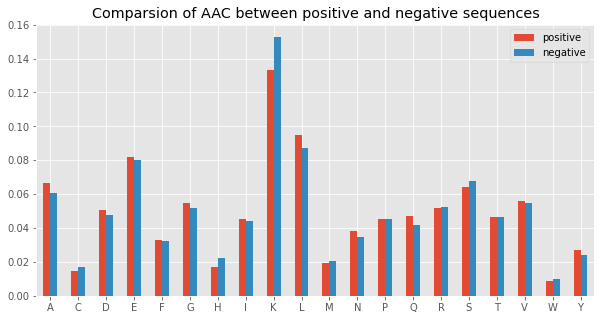

In [77]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5),dpi=200)
frq = pd.DataFrame([pos_frq, neg_frq], index=['positive', 'negative'])
frq.transpose().plot(kind='bar', figsize=(10, 5), rot=0)
plt.title('Comparsion of AAC between positive and negative sequences')